dis = 1.9553909039197133
Collision!!
dis = 2.3099337073570982
dis = 2.4698963348414305
dis = 2.42949725727208
Collision!!
Collision!!
dis = 2.337777037608647
Collision!!
dis = 2.4027736219079263
dis = 2.6430872387048923
dis = 2.237624972170223
Collision!!
dis = 1.9657079905513564
Collision!!
Collision!!
dis = 2.0798287333767345
Collision!!
Collision!!
dis = 2.2813875322006987
Collision!!
dis = 2.829341337839072
Collision!!
dis = 2.1377788508296525
dis = 1.9516494452584807
dis = 1.752207092380119
dis = 2.3606384378756884
dis = 2.5599411035900648
Collision!!
dis = 2.2150173658241936
Collision!!
dis = 2.6622964612514655
dis = 2.9948067986735953
dis = 2.114220286961175
dis = 2.235155263197268
dis = 2.2777251645910206
dis = 2.849546475459961
Collision!!
dis = 1.5531658120620158
dis = 3.148601225020976
dis = 3.129596434213389
dis = 2.196806870520542
dis = 3.143643061430048
dis = 2.0358303965232727
dis = 2.3452090730720596
dis = 2.6373320541038097
Collision!!
dis = 1.8363645354119507
Collisio

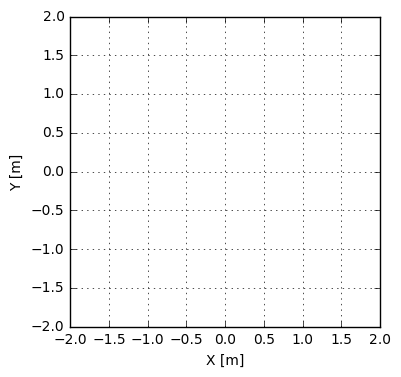

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import math

class RRT():
    def __init__(self, init, goal, obstacles):
        # 初期設定
        self.init_x = init[0]
        self.init_y = init[1]
        self.goal_x = goal[0]
        self.goal_y = goal[1]
        self.goal = goal
        self.obstacles = obstacles

        # パラメータ群
        # 伸ばし幅
        self.d = 0.2
        # 何回かに一回はゴールを選ぶ
        self.g_rate = 0.1
        # どこまでゴールに近づければいいか
        self.g_range = 0.1

        # 探索範囲
        self.MAX_x = 3
        self.MAX_y = 3
        self.min_x = -3
        self.min_y = -3

        # ノードを作成する
        # これはただのノード
        self.Nodes = np.array([[self.init_x, self.init_y]])
        # これはpath
        self.path_x = np.empty((0,2), float)
        self.path_y = np.empty((0,2), float)
        # samples
        self.samples = np.empty((0,2), float)

        self.nearest_node =None
        self.new_node =None

    def search(self):
        # 行動決定（何回かに一回はGoalを選ぶ）
        temp = np.random.randint(0, 10)
        if temp > 0:
            # random点を打つ(-1.5, 1.5の範囲で選ぶ)
            s_x = (np.random.rand() * self.MAX_x) - self.MAX_x/2
            s_y = (np.random.rand() * self.MAX_y) - self.MAX_y/2

            self.sample = np.array([s_x, s_y])
        else:
            # goalを選ぶ
            s_x = self.goal_x
            s_y = self.goal_y

            self.sample = np.array([s_x, s_y])

        # ノード探索
        distance = float('inf')
        self.nearest_node = None

        for i in range(self.Nodes.shape[0]):
            node = self.Nodes[i, :]
            part_MSE = (self.sample - node) * (self.sample - node)
            RMSE = math.sqrt(sum(part_MSE))

            # 距離が小さかったら追加
            if RMSE < distance:
                distance = RMSE
                self.nearest_node = node

        # 新ノードを作成
        pull = self.sample - self.nearest_node
        grad = math.atan2(pull[1], pull[0])

        d_x = math.cos(grad) * self.d
        d_y = math.sin(grad) * self.d

        self.new_node = self.nearest_node + np.array([d_x, d_y])

        return self.nearest_node, self.new_node

    def check_obstacles(self):
        obstacle_flag = False
        for i in range(self.obstacles.shape[0]):
            obs_dis = np.sqrt(sum((self.new_node - self.obstacles[i, :2]) * (self.new_node - self.obstacles[i, :2])))
            if obs_dis < self.obstacles[i, 2]:
                print('Collision!!')
                obstacle_flag = True

        return obstacle_flag

    def check_goal(self):
        dis = np.sqrt(sum((self.new_node - self.goal) *  (self.new_node - self.goal)))
        goal_flag = False
        print('dis = {0}'.format(dis))
        if dis < self.g_range:
            print('GOAL!!')
            goal_flag = True

        return goal_flag

    def path_make(self):# 追加処理
        # 新ノードを追加
        self.Nodes = np.vstack((self.Nodes, self.new_node))

        self.path_x = np.append(self.path_x, np.array([[self.nearest_node[0], self.new_node[0]]]), axis=0)
        self.path_y = np.append(self.path_y, np.array([[self.nearest_node[1], self.new_node[1]]]), axis=0)

        self.samples = np.append(self.samples, [[self.sample[0], self.sample[1]]], axis=0)

        return self.Nodes, self.path_x, self.path_y, self.samples

class Figures():
    def __init__(self):
        self.fig = plt.figure()
        self.axis = self.fig.add_subplot(111)

    def fig_set(self):
        # 初期設定
        MAX_x = 2
        min_x = -2
        MAX_y = 2
        min_y = -2

        self.axis.set_xlim(min_x, MAX_x)
        self.axis.set_ylim(min_y, MAX_y)

        # 軸
        self.axis.grid(True)

        # 縦横比
        self.axis.set_aspect('equal')

        # label
        self.axis.set_xlabel('X [m]')
        self.axis.set_ylabel('Y [m]')

    def plot(self, path_x, path_y, Nodes):
        self.axis.plot(path_x, path_y)
        self.axis.plot(Nodes[:, 0], Nodes[:, 1], '.', color='k')

        plt.show()

    def anim_plot(self, path_x, path_y, Nodes, samples, goal, obstacles):
        imgs = []
        finish_buffa = 20# 終了後もそのまま数秒表示したいので

        for i in range(path_x.shape[1] + finish_buffa):
            img = []
            if i >= path_x.shape[1]:
                i = path_x.shape[1] - 1
                img_text = self.axis.text(0.05, 0.9, 'step = {0}'.format(i), transform=self.axis.transAxes)
                img.append(img_text)
                img_goal_text = self.axis.text(0.35, 0.5, 'GOAL!!', transform=self.axis.transAxes, fontsize=30)
                img.append(img_goal_text)

            # step数を追加
            img_text = self.axis.text(0.05, 0.9, 'step = {0}'.format(i), transform=self.axis.transAxes)
            img.append(img_text)
            # goalを追加
            img_goal = self.axis.plot(goal[0], goal[1], '*', color='r')
            img.extend(img_goal)
            # obstaclesを追加
            for k in range(obstacles.shape[0]):
                circle_x, circle_y = self.circle_make(obstacles[k, 0], obstacles[k, 1], obstacles[k ,2])
                img_obstacle = self.axis.plot(circle_x, circle_y, color='k')
                img.extend(img_obstacle)

            # sampleを追加
            img_sample = self.axis.plot(samples[i, 0], samples[i, 1], '*', color='b')
            img.extend(img_sample)
            # nodeを追加
            img_nodes = self.axis.plot(Nodes[:i+2, 0], Nodes[:i+2, 1], '.', color='k')
            img.extend(img_nodes)

            # pathを追加
            for k in range(i+1):
                img_path = self.axis.plot(path_x[:, k], path_y[:, k], color='b')
                img.extend(img_path)

            print('i = {0}'.format(i))
            imgs.append(img)

        animation = ani.ArtistAnimation(self.fig, imgs)

        print('save_animation?')
        shuold_save_animation = int(input())

        if shuold_save_animation: 
            animation.save('basic_animation.gif', writer='imagemagick')

        plt.show()

    def circle_make(self, x, y, size):# 円作るよう
        # 初期化
        circle_x = [] #位置を表す円のx
        circle_y = [] #位置を表す円のy

        steps = 100 #円を書く分解能はこの程度で大丈夫
        for i in range(steps):
            circle_x.append(x + size*math.cos(i*2*math.pi/steps))
            circle_y.append(y + size*math.sin(i*2*math.pi/steps))

        return circle_x, circle_y


def main():
    # figures
    figure = Figures()
    figure.fig_set()


    # pathmake
    goal = [1.5, 1.5]
    init = [0.0, 0.0]
    obstacles = np.array([[-1, 1, 0.5], [0, -1, 0.5], [0.5, 0.5, 0.5]])
    path_planner = RRT(init, goal, obstacles)
    # iterations = 100

    while True:
        path_planner.search()
        obstacle_flag = path_planner.check_obstacles()
        if obstacle_flag: # 障害物あり
            pass
        else: # なし
            goal_flag = path_planner.check_goal()
            Nodes, path_x, path_y, samples = path_planner.path_make()
            if goal_flag :
                break

    # img用に処理
    path_x = path_x.transpose()
    path_y = path_y.transpose()

    figure.anim_plot(path_x, path_y, Nodes, samples, goal, obstacles)

if __name__ == '__main__':
    main()